In [147]:
import torch.nn as nn
import torch.nn.functional as F


class ProfileBayesClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_profiles, num_classes,p_y):
        super().__init__()
        self.num_profiles = num_profiles
        self.num_classes = num_classes
        self.p_y = p_y
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_profiles)
        )

        # 使用 register_buffer 保持状态但不被训练
        self.register_buffer("count_z_given_y", torch.zeros(num_profiles, num_classes))  # [T, K]

    def update_profile_counts(self, q_z_given_x, y_true):
        """
        使用 soft assignment 更新 profile 频数表：
        q_z_given_x: [B, T], y_true: [B]
        """
        with torch.no_grad():
            B, T = q_z_given_x.shape
            K = self.num_classes
            one_hot_y = F.one_hot(y_true, K).float()  # [B, K]
            # outer product: for each sample, update count[z, y]
            # Resulting shape: [B, T, K]
            contrib = torch.einsum("bt,bk->btk", q_z_given_x, one_hot_y)
            self.count_z_given_y += contrib.sum(dim=0)  # sum over batch

    def compute_p_z_given_y(self):
        # 避免除以 0：加入平滑
        smoothed = self.count_z_given_y + 1e-3
        return smoothed / smoothed.sum(dim=0, keepdim=True)  # [T, K]



    def forward(self, x):
        # q(Z|X)
        profile_logits = self.encoder(x)
        q_z_given_x = F.softmax(profile_logits, dim=1)  # [B, T]

        # Profile 后验
        p_z_given_y = self.compute_p_z_given_y()  # [T, K]

        # 归一化（每行归一）
        p_z = (p_z_given_y * self.p_y.unsqueeze(0)).sum(dim=1)  # shape [T]

        # 构造完整贝叶斯项：P(Z|Y)*P(Y) / P(Z)
        bayes_matrix = (p_z_given_y * self.p_y.unsqueeze(0)) / (p_z.unsqueeze(1) + 1e-9)  # [T, K]

        # 推理公式：P(Y|X) = sum_z P(Y|Z=z) * P(Z=z|X)
        p_y_given_x = q_z_given_x @ bayes_matrix  # shape [B, K]
        return p_y_given_x, q_z_given_x, p_z_given_y

    def predict(self, x):
        p_y_given_x, _, _ = self.forward(x)
        return p_y_given_x

def profile_entropy_regularization(q_z_given_x):
        avg_profile = q_z_given_x.mean(dim=0) + 1e-9
        return -torch.sum(avg_profile * avg_profile.log())

def profile_kl_regularization(q_z_given_x):
    avg_profile = q_z_given_x.mean(dim=0) + 1e-9
    log_avg = avg_profile.log()
    log_uniform = torch.full_like(log_avg, fill_value=torch.log(torch.tensor(1.0 / len(avg_profile))))
    return torch.sum(avg_profile * (log_avg - log_uniform))

In [148]:
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from dbc.utils import compute_prior

# 生成数据
X, y = datasets.make_blobs(
    n_samples=[125 * 5, 125 * 2],
    n_features=2,
    centers=[(9.5, 10), (10, 9.4)],
    cluster_std=[[0.6, 0.6], [0.35, 0.3]],
    shuffle=True
)

# 归一化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 分训练集与验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [149]:
import matplotlib.pyplot as plt
from dbc.main import KmeansDiscreteBayesianClassifier, DecisionTreeDiscreteBayesianClassifier
from dbc.utils import compute_conditional_risk
from sklearn.metrics import accuracy_score

DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=8)
DBC_kmeans.fit(X_train, y_train)
y_pred = DBC_kmeans.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'Kmeans Class condition risk: \n{conditional_risk[0]}')
print(f'\nKmeans Acc: \n{accuracy_score(y_val, y_pred)}')

Kmeans Class condition risk: 
[0.11956522 0.26582278]

Kmeans Acc: 
0.8365019011406845


In [150]:
DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=3)
DBC_DT.fit(X_train, y_train)
y_pred = DBC_DT.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'DT Class condition risk: \n{conditional_risk[0]}')
print(f'\nDT Acc: \n{accuracy_score(y_val, y_pred)}')

DT Class condition risk: 
[0.0923913 1.       ]

DT Acc: 
0.6349809885931559


In [151]:
p_y = torch.tensor(compute_prior(y_train, 2), dtype=torch.float32)

# 转成 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

Epoch   1: Train Loss=3.0936, Val Loss=2.0005 | Train Acc=0.7206 | Val Acc=0.6996
Epoch   2: Train Loss=3.0948, Val Loss=2.0003 | Train Acc=0.7206 | Val Acc=0.6996
Epoch   3: Train Loss=3.1020, Val Loss=1.9999 | Train Acc=0.7206 | Val Acc=0.6996
Epoch   4: Train Loss=3.1034, Val Loss=1.9992 | Train Acc=0.7206 | Val Acc=0.6996
Epoch   5: Train Loss=3.0910, Val Loss=1.9981 | Train Acc=0.7206 | Val Acc=0.6996
Epoch   6: Train Loss=3.0943, Val Loss=1.9958 | Train Acc=0.7206 | Val Acc=0.6996
Epoch   7: Train Loss=3.0951, Val Loss=1.9913 | Train Acc=0.7206 | Val Acc=0.6996
Epoch   8: Train Loss=3.0877, Val Loss=1.9836 | Train Acc=0.7206 | Val Acc=0.6996
Epoch   9: Train Loss=3.0807, Val Loss=1.9718 | Train Acc=0.7206 | Val Acc=0.6996
Epoch  10: Train Loss=3.0626, Val Loss=1.9515 | Train Acc=0.7206 | Val Acc=0.6996
Epoch  11: Train Loss=3.0434, Val Loss=1.9287 | Train Acc=0.7206 | Val Acc=0.6996
Epoch  12: Train Loss=3.0061, Val Loss=1.9007 | Train Acc=0.7206 | Val Acc=0.6996
Epoch  13: Train

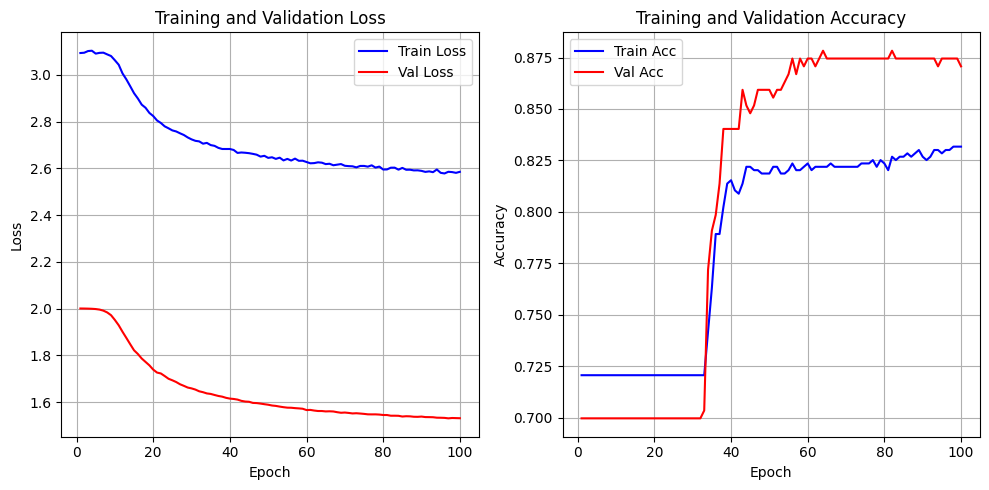

In [152]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


input_dim = 2  # 特征维度
hidden_dim = 64
num_profiles = 8
num_classes = 2

model = ProfileBayesClassifier(input_dim, hidden_dim, num_profiles, num_classes,p_y)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


num_epochs = 100
train_losses = []
val_losses = []  # 添加验证损失列表
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        p_y_given_x, q_z_given_x, _ = model(X_batch)
        model.update_profile_counts(q_z_given_x, y_batch)
        loss = criterion(p_y_given_x, y_batch) + 0.1 * profile_kl_regularization(q_z_given_x)
        loss.backward()
        optimizer.step()
        train_total_loss += loss.item()

        train_preds = torch.argmax(p_y_given_x, dim=1)
        train_correct += (train_preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_losses.append(train_total_loss)
    train_accuracies.append(train_correct / train_total)

    # 验证阶段
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            p_y_given_x = model.predict(X_batch)
            val_loss = criterion(p_y_given_x, y_batch)
            val_total_loss += val_loss.item()

            correct += (torch.argmax(p_y_given_x, dim=1) == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_total_loss)
    acc = correct / total
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1:3d}: Train Loss={train_total_loss:.4f}, Val Loss={val_total_loss:.4f} | Train Acc={train_accuracies[-1]:.4f} | Val Acc={acc:.4f}")

# 绘制训练和验证损失
plt.figure(figsize=(10, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

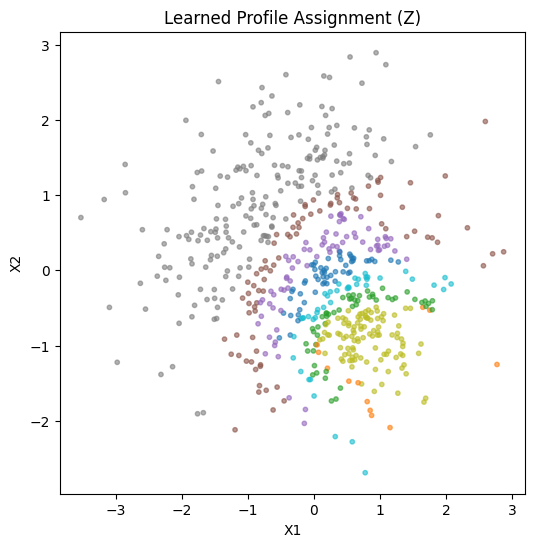

In [153]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    _, q_z_given_x, _ = model(X_train)
    Z_val = torch.argmax(q_z_given_x, dim=1)

plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Z_val, cmap="tab10", alpha=0.6, s=10)
plt.title("Learned Profile Assignment (Z)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


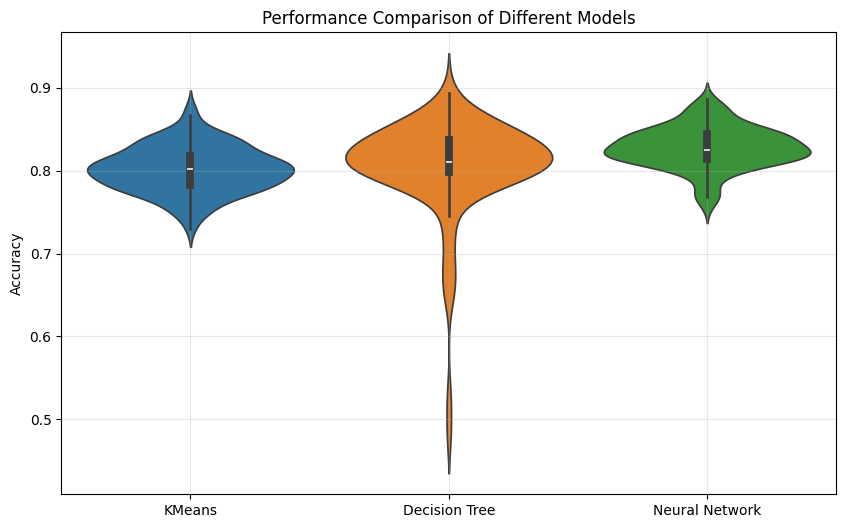

模型性能统计信息：

KMeans:
平均准确率: 0.8015
标准差: 0.0274

Decision Tree:
平均准确率: 0.8046
标准差: 0.0599

Neural Network:
平均准确率: 0.8278
标准差: 0.0249


In [155]:
# 执行100次实验并绘制性能比较小提琴图

import numpy as np
import seaborn as sns
from tqdm import tqdm

# 存储100次实验的结果
kmeans_accs = []
dt_accs = []
nn_accs = []

# 执行100次实验
for i in tqdm(range(100)):
    # 重新生成数据
    X, y = datasets.make_blobs(
        n_samples=[125 * 5, 125 * 2],
        n_features=2,
        centers=[(9.5, 10), (10, 9.4)],
        cluster_std=[[0.6, 0.6], [0.35, 0.3]],
        shuffle=True
    )

    # 归一化
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 分割数据
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

    # KMeans实验
    DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=8)
    DBC_kmeans.fit(X_train, y_train)
    y_pred_kmeans = DBC_kmeans.predict(X_val)
    kmeans_acc = accuracy_score(y_val, y_pred_kmeans)
    kmeans_accs.append(kmeans_acc)

    # 决策树实验
    DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=3)
    DBC_DT.fit(X_train, y_train)
    y_pred_dt = DBC_DT.predict(X_val)
    dt_acc = accuracy_score(y_val, y_pred_dt)
    dt_accs.append(dt_acc)

    # 神经网络实验
    p_y = torch.tensor(compute_prior(y_train, 2), dtype=torch.float32)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # 创建数据加载器
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # 初始化模型
    model = ProfileBayesClassifier(2, 64, 8, 2, p_y)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # 训练模型
    for epoch in range(100):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            p_y_given_x, q_z_given_x, _ = model(X_batch)
            model.update_profile_counts(q_z_given_x, y_batch)
            loss = criterion(p_y_given_x, y_batch) + 0.1 * profile_kl_regularization(q_z_given_x)
            loss.backward()
            optimizer.step()

    # 评估神经网络模型
    model.eval()
    with torch.no_grad():
        y_pred_nn = torch.argmax(model.predict(X_val_tensor), dim=1)
        nn_acc = accuracy_score(y_val_tensor, y_pred_nn)
        nn_accs.append(nn_acc)

# 创建绘图数据
plot_data = {
    'KMeans': kmeans_accs,
    'Decision Tree': dt_accs,
    'Neural Network': nn_accs
}

# 设置绘图样式
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_data)
plt.title('Performance Comparison of Different Models')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

# 打印统计信息
print("模型性能统计信息：")
print("\nKMeans:")
print(f"平均准确率: {np.mean(kmeans_accs):.4f}")
print(f"标准差: {np.std(kmeans_accs):.4f}")

print("\nDecision Tree:")
print(f"平均准确率: {np.mean(dt_accs):.4f}")
print(f"标准差: {np.std(dt_accs):.4f}")

print("\nNeural Network:")
print(f"平均准确率: {np.mean(nn_accs):.4f}")
print(f"标准差: {np.std(nn_accs):.4f}")